In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets import graphs as Graphs

import itertools
from typing import Optional

In [7]:
def print_graphs_tuple(g, data=True):
    for field_name in Graphs.ALL_FIELDS:
        per_replica_sample = getattr(g, field_name)
        if per_replica_sample is None:
            print(field_name, "EMPTY")
        else:
            print(field_name, "is with shape", per_replica_sample.shape)
            if data and  field_name != "edges":
                print(per_replica_sample)

### Creating graphs from networkx

[networkx](https://networkx.org/documentation/stable/tutorial.html) is a Python package for the study of graphs.


In [3]:
g = nx.DiGraph()

# add nodes
[g.add_node(idx, features=np.array([1.*idx])) for idx in range(4)];

# add edges
edge_lists = [(0, 1), (1, 2), (2, 3), (3, 0)]
[g.add_edge(i, j, features=np.array([abs(i-j)])) for i,j in edge_lists];

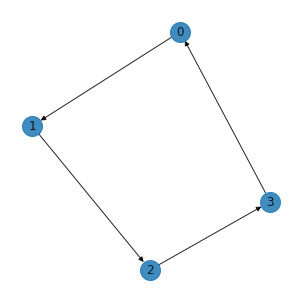

In [4]:
plt.figure(figsize=(4, 4))
pos = nx.spring_layout(g)
nx.draw(g, pos, node_size=400, alpha=0.85, node_color="#1f78b4", with_labels=True)

obtain the adjacency matrix

In [5]:
adj = np.asarray(nx.to_numpy_matrix(g))
adj

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [6]:
g.edges()

OutEdgeView([(0, 1), (1, 2), (2, 3), (3, 0)])

In [7]:
g_tuple = utils_np.networkxs_to_graphs_tuple([g])

In [8]:
g_tuple

GraphsTuple(nodes=array([[0.],
       [1.],
       [2.],
       [3.]]), edges=array([[1],
       [1],
       [1],
       [3]]), receivers=array([1, 2, 3, 0], dtype=int32), senders=array([0, 1, 2, 3], dtype=int32), globals=None, n_node=array([4], dtype=int32), n_edge=array([4], dtype=int32))

In [9]:
print_graphs_tuple(g_tuple)

nodes is with shape (4, 1)
[[0.]
 [1.]
 [2.]
 [3.]]
edges is with shape (4, 1)
receivers is with shape (4,)
[1 2 3 0]
senders is with shape (4,)
[0 1 2 3]
globals EMPTY
n_node is with shape (1,)
[4]
n_edge is with shape (1,)
[4]


### Create GraphsTuple using data-dict \[recommend\]

In [10]:
n_node = 4
n_node_features = 1
n_edge = 4
n_edge_features = 1
nodes = np.random.rand(n_node, n_node_features).astype(np.float32)
edges = np.random.rand(n_edge, n_edge_features).astype(np.float32)
receivers = np.array([1, 2, 3, 0])
senders = np.array([0, 1, 2, 3])
datadict = {
    "n_node": n_node,
    "n_edge": n_edge,
    "nodes": nodes,
    "edges": edges,
    "senders": senders,
    "receivers": receivers,
    "globals": np.array([0], dtype=np.float32)
}

In [11]:
g_tuple2 = utils_tf.data_dicts_to_graphs_tuple([datadict])

In [12]:
print_graphs_tuple(g_tuple2)

nodes is with shape (4, 1)
tf.Tensor(
[[0.88552785]
 [0.37593594]
 [0.58647484]
 [0.03406973]], shape=(4, 1), dtype=float32)
edges is with shape (4, 1)
receivers is with shape (4,)
tf.Tensor([1 2 3 0], shape=(4,), dtype=int32)
senders is with shape (4,)
tf.Tensor([0 1 2 3], shape=(4,), dtype=int32)
globals is with shape (1, 1)
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
n_node is with shape (1,)
tf.Tensor([4], shape=(1,), dtype=int32)
n_edge is with shape (1,)
tf.Tensor([4], shape=(1,), dtype=int32)


### Convert an event to a fully-connected graph

In [21]:
filename = '/global/homes/x/xju/atlas/data/top-tagger/test.h5'

In [22]:
with pd.HDFStore(filename, mode='r') as store:
    df = store['table']

In [23]:
df.head()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,E_199,PX_199,PY_199,PZ_199,truthE,truthPX,truthPY,truthPZ,ttv,is_signal_new
436,218.364243,-172.341858,110.129105,-76.503624,153.661118,-111.320465,93.167969,-50.390713,76.708054,-56.523701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
440,122.238762,26.738468,-91.613998,76.382225,121.227135,17.644758,-93.015450,75.715302,90.420105,21.377417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
441,383.772308,-97.906456,79.640709,-362.426361,200.625992,-54.921326,37.994343,-189.184753,123.247223,-33.828953,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
444,132.492752,-77.763947,-87.322601,-62.304600,83.946594,-49.450481,-53.823605,-41.288010,28.072624,-19.964916,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
445,730.786987,-209.120010,-193.454315,-672.973877,225.477325,-75.363350,-66.226990,-201.926651,217.040192,-63.698189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [24]:
df[df['is_signal_new'] == 1].head()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,E_199,PX_199,PY_199,PZ_199,truthE,truthPX,truthPY,truthPZ,ttv,is_signal_new
275,65.646370,-58.526817,29.698223,-1.439855,64.047226,-36.257854,46.957092,24.133938,46.889977,-26.141216,...,0.0,0.0,0.0,0.0,609.978516,-425.223938,360.547333,179.307800,1,1
278,182.433838,-67.388512,-150.770279,77.519150,105.039909,-24.843391,-70.149010,74.130325,99.697556,-25.996574,...,0.0,0.0,0.0,0.0,761.416626,-368.340454,-444.232635,466.554565,1,1
285,218.015808,-142.368179,19.166389,-163.996475,151.196808,-75.772964,7.036884,-130.649979,64.975327,-49.838360,...,0.0,0.0,0.0,0.0,1055.739014,-647.505615,54.828110,-814.257935,1,1
302,116.801796,90.702217,-54.621929,49.317455,87.957840,44.834236,-44.274315,61.369846,66.443222,31.902834,...,0.0,0.0,0.0,0.0,669.998962,439.078888,-269.705780,392.723145,1,1
308,114.989540,-70.048080,-66.881485,-61.989738,74.398933,-57.145046,-44.540745,-16.904631,48.529976,-37.200237,...,0.0,0.0,0.0,0.0,803.532227,-520.018433,-429.099030,-403.125366,1,1


In [25]:
event = df.iloc[0]
event

E_0              218.364243
PX_0            -172.341858
PY_0             110.129105
PZ_0             -76.503624
E_1              153.661118
                    ...    
truthPX            0.000000
truthPY            0.000000
truthPZ            0.000000
ttv                1.000000
is_signal_new      0.000000
Name: 436, Length: 806, dtype: float64

In [26]:
features = ['E', 'PX', 'PY', 'PZ']
scale = 0.001
solution = 'is_signal_new'

def make_graph(event, debug: Optional[bool] = False):
    n_max_nodes = 200
    n_nodes = 0
    nodes = []
    for inode in range(n_max_nodes):
        E_name = 'E_{}'.format(inode)
        if event[E_name] < 0.1:
            continue

        f_keynames = ['{}_{}'.format(x, inode) for x in features]
        n_nodes += 1
        nodes.append(event[f_keynames].values*scale)
    nodes = np.array(nodes, dtype=np.float32)

    # to make a bi-directional fully connected graph
    all_edges = list(itertools.combinations(range(n_nodes), 2))
    senders = np.array([x[0] for x in all_edges])
    receivers = np.array([x[1] for x in all_edges])
    n_edges = len(all_edges)
    edges = np.expand_dims(np.array([0.0]*n_edges, dtype=np.float32), axis=1)

    input_datadict = {
        "n_node": n_nodes,
        "n_edge": n_edges,
        "nodes": nodes,
        "edges": edges,
        "senders": senders,
        "receivers": receivers,
        "globals": np.array([n_nodes], dtype=np.float32)
    }
    target_datadict = {
        "n_node": n_nodes,
        "n_edge": n_edges,
        "nodes": nodes,
        "edges": edges,
        "senders": senders,
        "receivers": receivers,
        "globals": np.array([event[solution]], dtype=np.float32)
    }
    input_graph = utils_tf.data_dicts_to_graphs_tuple([input_datadict])
    target_graph = utils_tf.data_dicts_to_graphs_tuple([target_datadict])
    return [(input_graph, target_graph)]

In [27]:
graphs = make_graph(event)

In [28]:
g_evt_input, g_evt_target = graphs[0]

In [29]:
print_graphs_tuple(g_evt_input, data=False)

nodes is with shape (17, 4)
edges is with shape (136, 1)
receivers is with shape (136,)
senders is with shape (136,)
globals is with shape (1, 1)
n_node is with shape (1,)
n_edge is with shape (1,)


In [22]:
17*16//2

136

In [23]:
g_evt_target.globals

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>

Convert all events into graphs and save these graphs for training

In [30]:
def read(filename):
    with pd.HDFStore(filename, mode='r') as store:
        df = store['table']

    for ievt in range(df.shape[0]):
        yield df.iloc[ievt]

In [31]:
from root_gnn.src.datasets.base import DataSet

In [32]:
class TopTaggerDataset(DataSet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.read = read
        self.make_graph = make_graph

    def _num_evts(self, filename):
        with pd.HDFStore(filename, mode='r') as store:
            df = store['table']
        return df.shape[0]

In [33]:
data = TopTaggerDataset()

In [11]:
tr_filename = '/global/homes/x/xju/atlas/data/top-tagger/train.h5'
n_evts_per_record = 1000
debug = False
max_evts = 10000
num_workers = 1
overwrite = True

In [12]:
# using multiprocessing in jupyter notebook seems problematic..
data.process(filename=tr_filename, outname="TopTagger/trainning",\
    n_evts_per_record=n_evts_per_record, debug=debug,
    max_evts=max_evts, num_workers=num_workers, overwrite=overwrite)

Total 10,000 events are requested to be written to 10 files with 1 workers
TopTaggerDataset added 10,000 events, in 10.1 mins
0 events failed in being converted to graph


In [13]:
!ls TopTagger

trainning_0.tfrec  trainning_3.tfrec  trainning_6.tfrec  trainning_9.tfrec
trainning_1.tfrec  trainning_4.tfrec  trainning_7.tfrec
trainning_2.tfrec  trainning_5.tfrec  trainning_8.tfrec


In [31]:
!split_files_for_nn TopTagger inputs

2021-07-01 15:51:15.248901: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Shuffling input files
Total 10 files
Training   8 files
Validation 1 files
Testing    1 files
Traceback (most recent call last):
  File "/global/homes/x/xju/.conda/envs/tf2.4/bin/split_files_for_nn", line 62, in <module>
    split(**args.__dict__)
  File "/global/homes/x/xju/.conda/envs/tf2.4/bin/split_files_for_nn", line 41, in split
    my_copy(file_name, dest)
  File "/global/homes/x/xju/.conda/envs/tf2.4/bin/split_files_for_nn", line 9, in my_copy
    os.symlink(os.path.abspath(src), dest)
FileExistsError: [Errno 17] File exists: '/global/cfs/cdirs/atlas/xju/testarea/root_gnn/notebook/TopTagger/trainning_5.tfrec' -> 'inputs/train/trainning_5.tfrec'


In [14]:
!ls inputs

test  train  val


### 3. Training GNN

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets import graphs as Graphs
import sonnet as snt

import itertools
from typing import Optional


from root_gnn import model as Models
from root_gnn import losses
from root_gnn.trainer import Trainer

INFO:tensorflow:TF Version:2.4.1


In [34]:
help(Models)

Help on module root_gnn.model in root_gnn:

NAME
    root_gnn.model

DESCRIPTION
    The implementation of Graph Networks are mostly inspired by the ones in deepmind/graphs_nets
    https://github.com/deepmind/graph_nets

CLASSES
    root_gnn.src.models.edge_learner.EdgeLearnerBase(sonnet.src.base.Module)
        root_gnn.src.models.edge_learner.EdgeClassifier
        root_gnn.src.models.edge_learner.EdgeRegression
    root_gnn.src.models.global_learner.GlobalLearnerBase(sonnet.src.base.Module)
        root_gnn.src.models.global_learner.GlobalClassifier
        root_gnn.src.models.global_learner.GlobalRegression
    
    class EdgeClassifier(EdgeLearnerBase)
     |  EdgeClassifier(*args, **kwargs) -> ~T
     |  
     |  Base class for Sonnet modules.
     |  
     |  A Sonnet module is a lightweight container for variables and other modules.
     |  Modules typically define one or more "forward" methods (e.g. ``__call__``)
     |  which apply operations combining user input and module 

In [35]:
help(Models.GlobalRegression)

Help on class GlobalRegression in module root_gnn.src.models.global_learner:

class GlobalRegression(GlobalLearnerBase)
 |  GlobalRegression(*args, **kwargs) -> ~T
 |  
 |  Base class for Sonnet modules.
 |  
 |  A Sonnet module is a lightweight container for variables and other modules.
 |  Modules typically define one or more "forward" methods (e.g. ``__call__``)
 |  which apply operations combining user input and module parameters. For
 |  example::
 |  
 |      >>> class MultiplyModule(snt.Module):
 |      ...   def __call__(self, x):
 |      ...     if not hasattr(self, 'w'):
 |      ...       self.w = tf.Variable(2., name='w')
 |      ...     return x * self.w
 |  
 |      >>> mod = MultiplyModule()
 |      >>> mod(1.)
 |      <tf.Tensor: ... numpy=2.0>
 |  
 |  Sonnet modules are a layer on top of :tf:`Module`, implementing automatic name
 |  scoping as described in the original RFC :cite:`agarwal2019stateful`.
 |  
 |  Method resolution order:
 |      GlobalRegression
 |      G

In [36]:
model = Models.GlobalClassifier()

num_processing_steps_tr = 2
outputs_tr = model(g_evt_input, num_processing_steps_tr)

outputs_tr[-1].globals

g_evt_target.globals

In [37]:
loss_fcn = losses.GlobalLoss(real_global_weight=1., fake_global_weight=1.)

loss_fcn(g_evt_target, outputs_tr)

In [38]:
learning_rate = 0.0005
optimizer = snt.optimizers.Adam(learning_rate)

In [39]:

!ls inputs/train

trainning_0.tfrec  trainning_3.tfrec  trainning_5.tfrec  trainning_8.tfrec
trainning_1.tfrec  trainning_4.tfrec  trainning_7.tfrec  trainning_9.tfrec


In [19]:
# mode, -> 'rgr,globals', ['clf', 'rgr'], ['globals', 'edges']
trainer = Trainer(input_dir="inputs", output_dir="TrainedResults",
                  model=model, loss_fcn=loss_fcn, optimizer=optimizer,
                  evt_per_file=n_evts_per_record, mode='clf,globals', batch_size=10,
                  val_batches=10, log_freq=10, patiences=10)

INFO:tensorflow:Loading latest checkpoint from: TrainedResults/checkpoints


In [20]:
trainer.train(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Training starts with 80 graphs with batch size of 10 for 1 epochs
runing 1000 steps, 8 steps per epoch, and stop on variable val_loss
Tracing update_step


/global/homes/x/xju/.conda/envs/tf2.4/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/GlobalClassifier/MLPGraphNetwork/graph_network/edge_block/broadcast_receiver_nodes_to_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/GlobalClassifier/MLPGraphNetwork/graph_network/edge_block/broadcast_receiver_nodes_to_edges_3/Reshape:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradient_tape/GlobalClassifier/MLPGraphNetwork/graph_network/edge_block/broadcast_receiver_nodes_to_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/global/homes/x/xju/.conda/envs/tf2.4/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/GlobalClassifier/MLPG

Tracing update_step


  0%|          | 1/1000 [00:16<4:27:07, 16.04s/it]

>>>446,081 trainable parameters<<<


  4%|▍         | 40/1000 [00:57<06:32,  2.45it/s, acc=0.57, auc=0.637, loss=0.964, pre=0.481, rec=0.975, val_loss=0.669]/global/homes/x/xju/.conda/envs/tf2.4/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 13%|█▎        | 130/1000 [02:04<13:55,  1.04it/s, acc=0.53, auc=0.632, loss=0.656, pre=0.459, rec=0.975, val_loss=0.694]

Reached maximum failed attempts: 10 attempts. Stopping training


In [ ]:
# # add predictions
# results = model(test_input_graph)